# IEEE_CIS Fraud Detection Kaggle Competition

Arlens Zeqollari,  email: <arlens.zeqollari@gmail.com>

<img src="IEEE-CIS.jpg" width="800" height="400">

## Background

In this competition you are predicting the probability that an online transaction is fraudulent, as denoted by the binary target isFraud.

The data is broken into two files identity and transaction, which are joined by TransactionID. Not all transactions have corresponding identity information.

**Categorical Features - Transaction**
* ProductCD
* card1 - card6
* addr1, addr2
* P_emaildomain
* R_emaildomain
* M1 - M9

**Categorical Features - Identity**
* DeviceType
* DeviceInfo
* id_12 - id_38
* The TransactionDT feature is a timedelta from a given reference datetime (not an actual timestamp).

**Files**
* train_{transaction, identity}.csv - the training set
* test_{transaction, identity}.csv - the test set (you must predict the isFraud value for these observations)
* sample_submission.csv - a sample submission file in the correct format

# Import Required Packages

In [83]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from sklearn.model_selection import GridSearchCV


from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

from sklearn import preprocessing

import gc

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns',1000)

# Load Data

In [29]:
# Transaction CSVs
train_transaction = pd.read_csv('train_transaction.csv')
test_transaction = pd.read_csv('test_transaction.csv')

# Identity CSVs - These will be merged onto the transactions to create additional features
train_identity = pd.read_csv('train_identity.csv')
test_identity = pd.read_csv('test_identity.csv')

# Sample Submissions
ss = pd.read_csv('sample_submission.csv')

print('train_transaction shape is {}'.format(train_transaction.shape))
print('test_transaction shape is {}'.format(test_transaction.shape))
print('train_identity shape is {}'.format(train_identity.shape))
print('test_identity shape is {}'.format(test_identity.shape))

train_transaction shape is (590540, 394)
test_transaction shape is (506691, 393)
train_identity shape is (144233, 41)
test_identity shape is (141907, 41)


## Join transaction and identity data

In [30]:
train = pd.merge(train_transaction, train_identity, on='TransactionID', how='left')
test = pd.merge(test_transaction, test_identity, on='TransactionID', how='left')

## Reduce Memory Usage

In [31]:
del train_transaction, train_identity, test_identity, test_transaction

In [32]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

train=reduce_mem_usage(train)
test=reduce_mem_usage(test)

Mem. usage decreased to 650.48 Mb (66.8% reduction)
Mem. usage decreased to 565.37 Mb (66.3% reduction)


In [33]:
gc.collect()

28

# Feature Engineering

### Feature Engineering for Dubious Email Domains

In [62]:
# train['P_isproton']=(train['P_emaildomain']=='protonmail.com')
# train['R_isproton']=(train['R_emaildomain']=='protonmail.com')
# test['P_isproton']=(test['P_emaildomain']=='protonmail.com')
# test['R_isproton']=(test['R_emaildomain']=='protonmail.com')

# train['P_anonymous']=(train['P_emaildomain']=='anonymous.com')
# train['R_anonymous']=(train['R_emaildomain']=='anonymous.com')
# test['P_anonymous']=(test['P_emaildomain']=='anonymous.com')
# test['R_anonymous']=(test['R_emaildomain']=='anonymous.com')

### One-Hot Encoding for card4

In [34]:
train = pd.concat([train, pd.get_dummies(train.card4,prefix='card4')], axis=1)
test = pd.concat([test, pd.get_dummies(test.card4, prefix='card4')], axis=1)

### One-Hot Encoding for ProductCD

In [35]:
train = pd.concat([train, pd.get_dummies(train.ProductCD,prefix='ProductCD')], axis=1)
test = pd.concat([test, pd.get_dummies(test.ProductCD, prefix='ProductCD')], axis=1)

### One-Hot Encoding for card6

In [36]:
train = pd.concat([train, pd.get_dummies(train.card6,prefix='card6')], axis=1)
test = pd.concat([test, pd.get_dummies(test.card6, prefix='card6')], axis=1)

### One-Hot Encoding for P_emaildomain

In [37]:
train = pd.concat([train, pd.get_dummies(train.P_emaildomain,prefix='P_emaildomain')], axis=1)
test = pd.concat([test, pd.get_dummies(test.P_emaildomain, prefix='P_emaildomain')], axis=1)

### One-Hot Encoding for R_emaildomain

In [38]:
train = pd.concat([train, pd.get_dummies(train.R_emaildomain,prefix='R_emaildomain')], axis=1)
test = pd.concat([test, pd.get_dummies(test.R_emaildomain, prefix='R_emaildomain')], axis=1)

### Feature Engineering for Transaction Day of Week and Hour of Day

In [39]:
train['Transaction_day_of_week'] = np.floor((train['TransactionDT'] / (3600 * 24) - 1) % 7)
test['Transaction_day_of_week'] = np.floor((test['TransactionDT'] / (3600 * 24) - 1) % 7)

train['Transaction_hour_of_day'] = np.floor(train['TransactionDT'] / 3600) % 24
test['Transaction_hour_of_day'] = np.floor(test['TransactionDT'] / 3600) % 24

train['TransactionAmt_decimal'] = ((train['TransactionAmt'] - train['TransactionAmt'].astype(int)) * 1000).astype(int)
test['TransactionAmt_decimal'] = ((test['TransactionAmt'] - test['TransactionAmt'].astype(int)) * 1000).astype(int)

### Cleaning up *device_name* column

In [40]:
def setDevice(df):
    df['DeviceInfo'] = df['DeviceInfo'].fillna('unknown_device').str.lower()
    
    df['device_name'] = df['DeviceInfo'].str.split('/', expand=True)[0]

    df.loc[df['device_name'].str.contains('SM', na=False), 'device_name'] = 'Samsung'
    df.loc[df['device_name'].str.contains('SAMSUNG', na=False), 'device_name'] = 'Samsung'
    df.loc[df['device_name'].str.contains('GT-', na=False), 'device_name'] = 'Samsung'
    df.loc[df['device_name'].str.contains('Moto G', na=False), 'device_name'] = 'Motorola'
    df.loc[df['device_name'].str.contains('Moto', na=False), 'device_name'] = 'Motorola'
    df.loc[df['device_name'].str.contains('moto', na=False), 'device_name'] = 'Motorola'
    df.loc[df['device_name'].str.contains('LG-', na=False), 'device_name'] = 'LG'
    df.loc[df['device_name'].str.contains('rv:', na=False), 'device_name'] = 'RV'
    df.loc[df['device_name'].str.contains('HUAWEI', na=False), 'device_name'] = 'Huawei'
    df.loc[df['device_name'].str.contains('ALE-', na=False), 'device_name'] = 'Huawei'
    df.loc[df['device_name'].str.contains('-L', na=False), 'device_name'] = 'Huawei'
    df.loc[df['device_name'].str.contains('Blade', na=False), 'device_name'] = 'ZTE'
    df.loc[df['device_name'].str.contains('BLADE', na=False), 'device_name'] = 'ZTE'
    df.loc[df['device_name'].str.contains('Linux', na=False), 'device_name'] = 'Linux'
    df.loc[df['device_name'].str.contains('XT', na=False), 'device_name'] = 'Sony'
    df.loc[df['device_name'].str.contains('HTC', na=False), 'device_name'] = 'HTC'
    df.loc[df['device_name'].str.contains('ASUS', na=False), 'device_name'] = 'Asus'

    df.loc[df.device_name.isin(df.device_name.value_counts()[df.device_name.value_counts() < 200].index), 'device_name'] = "Others"
    df['had_id'] = 1
    
    return df

train=setDevice(train)
test=setDevice(test)

### One-Hot Encoding for device_name

In [41]:
train = pd.concat([train, pd.get_dummies(train.device_name,prefix='device_name')], axis=1)
test = pd.concat([test, pd.get_dummies(test.device_name, prefix='device_name')], axis=1)

### One_Hot Encoding for id_30 (device OS)

In [42]:
train = pd.concat([train, pd.get_dummies(train.id_30,prefix='id_30')], axis=1)
test = pd.concat([test, pd.get_dummies(test.id_30, prefix='id_30')], axis=1)

### One_Hot Encoding for id_31 (browser)

In [43]:
train = pd.concat([train, pd.get_dummies(train.id_31,prefix='id_31')], axis=1)
test = pd.concat([test, pd.get_dummies(test.id_31, prefix='id_31')], axis=1)

### One_Hot Encoding for id_34 (match_status)

In [44]:
train = pd.concat([train, pd.get_dummies(train.id_34,prefix='id_34')], axis=1)
test = pd.concat([test, pd.get_dummies(test.id_34, prefix='id_34')], axis=1)

### One_Hot Encoding for id_33 (device resolution)

In [45]:
# train = pd.concat([train, pd.get_dummies(train.id_33,prefix='id_33')], axis=1)
# test = pd.concat([test, pd.get_dummies(test.id_33, prefix='id_33')], axis=1)

### One_Hot Encoding for id_12

In [46]:
train = pd.concat([train, pd.get_dummies(train.id_12,prefix='id_12')], axis=1)
test = pd.concat([test, pd.get_dummies(test.id_12, prefix='id_12')], axis=1)

### One_Hot Encoding for id_15

In [47]:
train = pd.concat([train, pd.get_dummies(train.id_15,prefix='id_15')], axis=1)
test = pd.concat([test, pd.get_dummies(test.id_15, prefix='id_15')], axis=1)

### One_Hot Encoding for DeviceType

In [48]:
train = pd.concat([train, pd.get_dummies(train.DeviceType,prefix='DeviceType')], axis=1)
test = pd.concat([test, pd.get_dummies(test.DeviceType, prefix='DeviceType')], axis=1)

### One_Hot Encoding for M4

In [49]:
train = pd.concat([train, pd.get_dummies(train.M4,prefix='M4')], axis=1)
test = pd.concat([test, pd.get_dummies(test.M4, prefix='M4')], axis=1)

### Create number of NaNs Feature

In [50]:
train['num_nulls'] = train.isnull().sum(axis=1)
test['num_nulls'] = test.isnull().sum(axis=1)

### Drop original columns that were one-hot encoded

In [51]:
cols_to_drop = ["card4","ProductCD","card6","P_emaildomain","R_emaildomain","device_name","id_12","id_15","id_30","id_31","id_33","id_34","M4","DeviceInfo","DeviceType"]
train.drop(columns = cols_to_drop,inplace=True)
test.drop(columns = cols_to_drop,inplace=True)
train.head(10)

,TransactionID,isFraud,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,addr2,dist1,dist2,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M5,M6,M7,M8,M9,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_13,id_14,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_32,id_35,id_36,id_37,id_38,card4_american express,card4_discover,card4_mastercard,card4_visa,ProductCD_C,ProductCD_H,ProductCD_R,ProductCD_S,ProductCD_W,card6_charge card,card6_credit,card6_debit,card6_debit or credit,P_emaildomain_aim.com,P_emaildomain_anonymous.com,P_emaildomain_aol.com,P_emaildomain_att.net,P_emaildomain_bellsouth.net,P_emaildomain_cableone.net,P_emaildomain_centurylink.net,P_emaildomain_cfl.rr.com,P_emaildomain_charter.net,P_emaildomain_comcast.net,P_emaildomain_cox.net,P_emaildomain_earthlink.net,P_emaildomain_embarqmail.com,P_emaildomain_frontier.com,P_emaildomain_frontiernet.net,P_emaildomain_gmail,P_emaildomain_gmail.com,P_emaildomain_gmx.de,P_emaildomain_hotmail.co.uk,P_emaildomain_hotmail.com,P_emaildomain_hotmail.de,P_emaildomain_hotmail.es,P_emaildomain_hotmail.fr,P_emaildomain_icloud.com,P_emaildomain_juno.com,P_emaildomain_live.com,P_emaildomain_live.com.mx,P_emaildomain_live.fr,P_emaildomain_mac.com,P_emaildomain_mail.com,P_emaildomain_me.com,P_emaildomain_msn.com,P_emaildomain_netzero.com,P_emaildomain_netzero.net,P_emaildomain_optonline.net,P_emaildomain_outlook.com,P_emaildomain_outlook.es,P_emaildomain_prodigy.net.mx,P_emaildomain_protonmail.com,P_emaildomain_ptd.net,P_emaildomain_q.com,P_emaildomain_roadrunner.com,P_emaildomain_rocketmail.com,P_emaildomain_sbcglobal.net,P_emaildomain_sc.rr.com,P_emaildomain_servicios-ta.com,P_emaildomain_suddenlink.net,P_emaildomain_twc.com,P_emaildomain_verizon.net,P_emaildomain_web.de,P_emaildomain_windstream.net,P_emaildomain_yahoo.co.jp,P_emaildomain_yahoo.co.uk,P_emaildomain_yahoo.com,P_emaildomain_yahoo.com.mx,P_emaildomain_yahoo.de,P_emaildomain_yahoo.es,P_emaildomain_yahoo.fr,P_emaildomain_ymail.com,R_emaildomain_aim.com,R_emaildomain_anonymous.com,R_emaildomain_aol.com,R_emaildomain_att.net,R_emaildomain_bellsouth.net,R_emaildomain_cableone.net,R_emaildomain_centurylink.net,R_emaildomain_cfl.rr.com,R_emaildomain_charter.net,R_emaildomain_comcast.net,R_emaildomain_cox.net,R_emaildomain_earthlink.net,R_emaildomain_

# Data Processing

In [ ]:
model_7_features = ['isFraud','TransactionID','TransactionDT','TransactionAmt','TransactionAmt_decimal','ProductCD',
                   'card1','card2','card3','card4','card5','card6','addr1','addr2','dist1',
                   'P_emaildomain','R_emaildomain',
                   'D1','D2','D14','D15','C8','V315','num_nulls','Transaction_hour_of_day',
                   'C2','D7','V45','D8','V333','V265','V189','D4','V318','D10','V274',
                   'V29','Transaction_day_of_week','device_name','P_isproton','R_isproton',
                   'P_anonymous','R_anonymous']

train = train[model_7_features]

## Drop columns with >90% missing values

In [52]:
perc_thresh = .10
thresh_train = len(train) * perc_thresh
train = train.dropna(thresh = thresh_train, axis = 'columns')

print('train shape is {}'.format(train.shape))

train shape is (590540, 786)


In [53]:
current_test_columns = test.columns
cols_to_keep = []
cols_to_keep = [x for x in train.columns if x != 'isFraud' and x in current_test_columns]

test = test[cols_to_keep]
cols_to_keep.append('isFraud')
train = train[cols_to_keep]

print('train shape is {}'.format(train.shape))
print('test shape is {}'.format(test.shape))

train shape is (590540, 737)
test shape is (506691, 736)


## Fill N/A with -999

In [54]:
train = train.fillna(-999)
test = test.fillna(-999)

## Prepare data for validation / modeling

In [55]:
X = train.drop(['isFraud','TransactionID','TransactionDT'],axis='columns')
X.head()

,TransactionAmt,card1,card2,card3,card5,addr1,addr2,dist1,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M5,M6,M7,M8,M9,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339,id_01,id_02,id_03,id_04,id_05,id_06,id_09,id_10,id_11,id_13,id_14,id_16,id_17,id_19,id_20,id_28,id_29,id_32,id_35,id_36,id_37,id_38,card4_american express,card4_discover,card4_mastercard,card4_visa,ProductCD_C,ProductCD_H,ProductCD_R,ProductCD_S,ProductCD_W,card6_charge card,card6_credit,card6_debit,P_emaildomain_aim.com,P_emaildomain_anonymous.com,P_emaildomain_aol.com,P_emaildomain_att.net,P_emaildomain_bellsouth.net,P_emaildomain_cableone.net,P_emaildomain_centurylink.net,P_emaildomain_cfl.rr.com,P_emaildomain_charter.net,P_emaildomain_comcast.net,P_emaildomain_cox.net,P_emaildomain_earthlink.net,P_emaildomain_embarqmail.com,P_emaildomain_frontier.com,P_emaildomain_frontiernet.net,P_emaildomain_gmail,P_emaildomain_gmail.com,P_emaildomain_gmx.de,P_emaildomain_hotmail.co.uk,P_emaildomain_hotmail.com,P_emaildomain_hotmail.de,P_emaildomain_hotmail.es,P_emaildomain_hotmail.fr,P_emaildomain_icloud.com,P_emaildomain_juno.com,P_emaildomain_live.com,P_emaildomain_live.com.mx,P_emaildomain_live.fr,P_emaildomain_mac.com,P_emaildomain_mail.com,P_emaildomain_me.com,P_emaildomain_msn.com,P_emaildomain_netzero.com,P_emaildomain_netzero.net,P_emaildomain_optonline.net,P_emaildomain_outlook.com,P_emaildomain_outlook.es,P_emaildomain_prodigy.net.mx,P_emaildomain_protonmail.com,P_emaildomain_ptd.net,P_emaildomain_q.com,P_emaildomain_roadrunner.com,P_emaildomain_rocketmail.com,P_emaildomain_sbcglobal.net,P_emaildomain_sc.rr.com,P_emaildomain_servicios-ta.com,P_emaildomain_suddenlink.net,P_emaildomain_twc.com,P_emaildomain_verizon.net,P_emaildomain_web.de,P_emaildomain_windstream.net,P_emaildomain_yahoo.co.jp,P_emaildomain_yahoo.co.uk,P_emaildomain_yahoo.com,P_emaildomain_yahoo.com.mx,P_emaildomain_yahoo.de,P_emaildomain_yahoo.es,P_emaildomain_yahoo.fr,P_emaildomain_ymail.com,R_emaildomain_aim.com,R_emaildomain_anonymous.com,R_emaildomain_aol.com,R_emaildomain_att.net,R_emaildomain_bellsouth.net,R_emaildomain_cableone.net,R_emaildomain_centurylink.net,R_emaildomain_cfl.rr.com,R_emaildomain_charter.net,R_emaildomain_comcast.net,R_emaildomain_cox.net,R_emaildomain_earthlink.net,R_emaildomain_embarqmail.com,R_emaildomain_frontier.com,R_emaildomain_frontiernet.net,R_emaildomain_gmail,R_emaildomain_gmail.com,R_emaildoma

In [56]:
test = test.drop(['TransactionID','TransactionDT'],axis='columns')
test.head()

,TransactionAmt,card1,card2,card3,card5,addr1,addr2,dist1,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M5,M6,M7,M8,M9,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339,id_01,id_02,id_03,id_04,id_05,id_06,id_09,id_10,id_11,id_13,id_14,id_16,id_17,id_19,id_20,id_28,id_29,id_32,id_35,id_36,id_37,id_38,card4_american express,card4_discover,card4_mastercard,card4_visa,ProductCD_C,ProductCD_H,ProductCD_R,ProductCD_S,ProductCD_W,card6_charge card,card6_credit,card6_debit,P_emaildomain_aim.com,P_emaildomain_anonymous.com,P_emaildomain_aol.com,P_emaildomain_att.net,P_emaildomain_bellsouth.net,P_emaildomain_cableone.net,P_emaildomain_centurylink.net,P_emaildomain_cfl.rr.com,P_emaildomain_charter.net,P_emaildomain_comcast.net,P_emaildomain_cox.net,P_emaildomain_earthlink.net,P_emaildomain_embarqmail.com,P_emaildomain_frontier.com,P_emaildomain_frontiernet.net,P_emaildomain_gmail,P_emaildomain_gmail.com,P_emaildomain_gmx.de,P_emaildomain_hotmail.co.uk,P_emaildomain_hotmail.com,P_emaildomain_hotmail.de,P_emaildomain_hotmail.es,P_emaildomain_hotmail.fr,P_emaildomain_icloud.com,P_emaildomain_juno.com,P_emaildomain_live.com,P_emaildomain_live.com.mx,P_emaildomain_live.fr,P_emaildomain_mac.com,P_emaildomain_mail.com,P_emaildomain_me.com,P_emaildomain_msn.com,P_emaildomain_netzero.com,P_emaildomain_netzero.net,P_emaildomain_optonline.net,P_emaildomain_outlook.com,P_emaildomain_outlook.es,P_emaildomain_prodigy.net.mx,P_emaildomain_protonmail.com,P_emaildomain_ptd.net,P_emaildomain_q.com,P_emaildomain_roadrunner.com,P_emaildomain_rocketmail.com,P_emaildomain_sbcglobal.net,P_emaildomain_sc.rr.com,P_emaildomain_servicios-ta.com,P_emaildomain_suddenlink.net,P_emaildomain_twc.com,P_emaildomain_verizon.net,P_emaildomain_web.de,P_emaildomain_windstream.net,P_emaildomain_yahoo.co.jp,P_emaildomain_yahoo.co.uk,P_emaildomain_yahoo.com,P_emaildomain_yahoo.com.mx,P_emaildomain_yahoo.de,P_emaildomain_yahoo.es,P_emaildomain_yahoo.fr,P_emaildomain_ymail.com,R_emaildomain_aim.com,R_emaildomain_anonymous.com,R_emaildomain_aol.com,R_emaildomain_att.net,R_emaildomain_bellsouth.net,R_emaildomain_cableone.net,R_emaildomain_centurylink.net,R_emaildomain_cfl.rr.com,R_emaildomain_charter.net,R_emaildomain_comcast.net,R_emaildomain_cox.net,R_emaildomain_earthlink.net,R_emaildomain_embarqmail.com,R_emaildomain_frontier.com,R_emaildomain_frontiernet.net,R_emaildomain_gmail,R_emaildomain_gmail.com,R_emaildoma

In [57]:
y = train['isFraud']

## Encode categorical variables

In [58]:
for f in X.columns:
    if X[f].dtype=='object' or test[f].dtype=='object': 
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(X[f].values) + list(test[f].values))
        X[f] = lbl.transform(list(X[f].values))
        test[f] = lbl.transform(list(test[f].values))

In [59]:
X.head()

,TransactionAmt,card1,card2,card3,card5,addr1,addr2,dist1,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M5,M6,M7,M8,M9,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339,id_01,id_02,id_03,id_04,id_05,id_06,id_09,id_10,id_11,id_13,id_14,id_16,id_17,id_19,id_20,id_28,id_29,id_32,id_35,id_36,id_37,id_38,card4_american express,card4_discover,card4_mastercard,card4_visa,ProductCD_C,ProductCD_H,ProductCD_R,ProductCD_S,ProductCD_W,card6_charge card,card6_credit,card6_debit,P_emaildomain_aim.com,P_emaildomain_anonymous.com,P_emaildomain_aol.com,P_emaildomain_att.net,P_emaildomain_bellsouth.net,P_emaildomain_cableone.net,P_emaildomain_centurylink.net,P_emaildomain_cfl.rr.com,P_emaildomain_charter.net,P_emaildomain_comcast.net,P_emaildomain_cox.net,P_emaildomain_earthlink.net,P_emaildomain_embarqmail.com,P_emaildomain_frontier.com,P_emaildomain_frontiernet.net,P_emaildomain_gmail,P_emaildomain_gmail.com,P_emaildomain_gmx.de,P_emaildomain_hotmail.co.uk,P_emaildomain_hotmail.com,P_emaildomain_hotmail.de,P_emaildomain_hotmail.es,P_emaildomain_hotmail.fr,P_emaildomain_icloud.com,P_emaildomain_juno.com,P_emaildomain_live.com,P_emaildomain_live.com.mx,P_emaildomain_live.fr,P_emaildomain_mac.com,P_emaildomain_mail.com,P_emaildomain_me.com,P_emaildomain_msn.com,P_emaildomain_netzero.com,P_emaildomain_netzero.net,P_emaildomain_optonline.net,P_emaildomain_outlook.com,P_emaildomain_outlook.es,P_emaildomain_prodigy.net.mx,P_emaildomain_protonmail.com,P_emaildomain_ptd.net,P_emaildomain_q.com,P_emaildomain_roadrunner.com,P_emaildomain_rocketmail.com,P_emaildomain_sbcglobal.net,P_emaildomain_sc.rr.com,P_emaildomain_servicios-ta.com,P_emaildomain_suddenlink.net,P_emaildomain_twc.com,P_emaildomain_verizon.net,P_emaildomain_web.de,P_emaildomain_windstream.net,P_emaildomain_yahoo.co.jp,P_emaildomain_yahoo.co.uk,P_emaildomain_yahoo.com,P_emaildomain_yahoo.com.mx,P_emaildomain_yahoo.de,P_emaildomain_yahoo.es,P_emaildomain_yahoo.fr,P_emaildomain_ymail.com,R_emaildomain_aim.com,R_emaildomain_anonymous.com,R_emaildomain_aol.com,R_emaildomain_att.net,R_emaildomain_bellsouth.net,R_emaildomain_cableone.net,R_emaildomain_centurylink.net,R_emaildomain_cfl.rr.com,R_emaildomain_charter.net,R_emaildomain_comcast.net,R_emaildomain_cox.net,R_emaildomain_earthlink.net,R_emaildomain_embarqmail.com,R_emaildomain_frontier.com,R_emaildomain_frontiernet.net,R_emaildomain_gmail,R_emaildomain_gmail.com,R_emaildoma

# Hyperparameter Tuning

## Split dataset into training set and validation set

In [137]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.20, random_state = 747)

## Build Models

### AdaBoost Classifier

In [84]:
ABC = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=2),
    n_estimators=200,
    learning_rate=1)
ABC.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          learning_rate=1, n_estimators=200, random_state=None)

In [85]:
#y_val_pred = ABC.predict(X_val)
y_val_pred_proba = ABC.predict_proba(X_val)

### xgBoost Classifier

In [138]:
dtrain = xgb.DMatrix(data=X_train,label=y_train)

In [139]:
clf = xgb.XGBClassifier(
    n_estimators=500,
    max_depth=5,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.5,
    missing=-999,
    nthread = 4,
    n_jobs = 4,
    random_state=10,
    verbosity = 2
)

In [129]:
clf.fit(X_train, y_train, eval_metric='auc')

[12:02:29] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=5
[12:02:31] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=5
[12:02:34] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[12:02:36] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=5
[12:02:39] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=5
[12:02:42] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=5
[12:02:44] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=5
[12:02:47] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[12:02:50] INFO: src/tree/updater_prune.cc:74: tree prun

[12:05:32] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=5
[12:05:35] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=5
[12:05:38] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=5
[12:05:40] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[12:05:43] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=5
[12:05:46] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=5
[12:05:48] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=5
[12:05:51] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=5
[12:05:53] INFO: src/tree/updater_prune.cc:74: tree prun

[12:08:36] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=5
[12:08:39] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=5
[12:08:41] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=5
[12:08:44] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=5
[12:08:47] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=5
[12:08:49] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=5
[12:08:52] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=5
[12:08:55] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=5
[12:08:57] INFO: src/tree/updater_prune.cc:74: tree prun

[12:11:39] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[12:11:41] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=5
[12:11:44] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=5
[12:11:47] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=5
[12:11:49] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=5
[12:11:52] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=5
[12:11:54] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=5
[12:11:57] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=5
[12:11:59] INFO: src/tree/updater_prune.cc:74: tree prun

[12:14:39] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=5
[12:14:42] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=5
[12:14:45] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=5
[12:14:47] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=5
[12:14:50] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=5
[12:14:53] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=5
[12:14:55] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=5
[12:14:58] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=5
[12:15:00] INFO: src/tree/updater_prune.cc:74: tree prun

[12:17:38] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=5
[12:17:41] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=5
[12:17:43] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[12:17:46] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=5
[12:17:48] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=5
[12:17:51] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=5
[12:17:53] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=5
[12:17:56] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=5
[12:17:58] INFO: src/tree/updater_prune.cc:74: tree prun

[12:20:35] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=5
[12:20:37] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=5
[12:20:40] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=5
[12:20:42] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=5
[12:20:45] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=5
[12:20:47] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=5
[12:20:50] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=5
[12:20:53] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=5
[12:20:55] INFO: src/tree/updater_prune.cc:74: tree prun

[12:23:31] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=5
[12:23:34] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[12:23:36] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=5
[12:23:39] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[12:23:41] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[12:23:44] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=5
[12:23:46] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[12:23:49] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=5
[12:23:52] INFO: src/tree/updater_prune.cc:74: tree prun

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.5, gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=5,
       min_child_weight=1, missing=-999, n_estimators=500, n_jobs=4,
       nthread=4, objective='binary:logistic', random_state=10,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=0.8, verbosity=2)

In [130]:
y_val_pred_proba = clf.predict_proba(X_val)

### ROC Curve

In [131]:
# Evaluate test-set roc_auc_score
ada_roc_auc = roc_auc_score(y_val, y_val_pred_proba[:,1])

# Print roc_auc_score
print('ROC AUC score: {:.4f}'.format(ada_roc_auc))

ROC AUC score: 0.9263


In [132]:
fpr, tpr, thresholds = roc_curve(y_val, y_val_pred_proba[:,1])

In [133]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, "b:", label=label, linewidth=2)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    plt.title('ROC Curve')
    plt.legend()

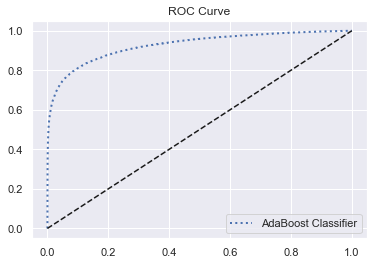

In [134]:
plot_roc_curve(fpr, tpr, label='AdaBoost Classifier')
plt.show()

### Hyperparameter Tuning

In [ ]:
param_grid = {
 'n_estimators': [500,750],
 'learning_rate' : [.01, .1, 1],
 }

ABC = AdaBoostClassifier()

grid_search = GridSearchCV(ABC, param_grid, 
                           cv=3, scoring='roc_auc',
                           n_jobs = -1, verbose=True)
grid_search.fit(X_train, y_train)

In [ ]:
grid_search.best_params_

In [ ]:
grid_search.best_score_

### Best Model Thus Far

* Drop columns with >10% missing.

* xgb.XGBClassifier(

    * n_estimators=500,
    * max_depth=5,
    * learning_rate=0.1,
    * subsample=0.8,
    * colsample_bytree=0.5,
    * missing=-999,
    * nthread = 4,
    * n_jobs = 4,
    * random_state=10,
    * verbosity = 2
)

* Validation AUC: 0.9263
* Test AUC: 0.9176

# Build Final Predictions

## Train and Fit on Full Training Data

#### ADABOOST

In [ ]:
ABC = AdaBoostClassifier(
    n_estimators=500,
    learning_rate=1)
ABC.fit(X, y)

In [90]:
#y_test_pred = ABC.predict(test)
y_test_pred_proba = ABC.predict_proba(test)

#### XGBOOST

In [140]:
dtrain = xgb.DMatrix(data=X,label=y)

In [141]:
clf = xgb.XGBClassifier(
    n_estimators=500,
    max_depth=5,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.5,
    missing=-999,
    nthread = 4,
    n_jobs = 4,
    random_state=10,
    verbosity = 2
)

In [144]:
clf.fit(X, y, eval_metric='auc')

[12:53:35] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[12:53:49] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[12:54:02] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[12:54:16] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[12:54:29] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=5
[12:54:43] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[12:54:56] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[12:55:10] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[12:55:24] INFO: src/tree/updater_prune.cc:74: tree prun

[13:10:08] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[13:10:21] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[13:10:35] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=5
[13:10:49] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=5
[13:11:04] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[13:11:19] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=5
[13:11:34] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=5
[13:11:49] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[13:12:03] INFO: src/tree/updater_prune.cc:74: tree prun

[13:26:26] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=5
[13:26:39] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=5
[13:26:52] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=5
[13:27:06] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=5
[13:27:19] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[13:27:33] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=5
[13:27:46] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=5
[13:28:00] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=5
[13:28:13] INFO: src/tree/updater_prune.cc:74: tree prun

[13:43:01] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=5
[13:43:17] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=5
[13:43:32] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=5
[13:43:47] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[13:44:01] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=5
[13:44:15] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=5
[13:44:30] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=5
[13:44:44] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[13:44:58] INFO: src/tree/updater_prune.cc:74: tree prun

[13:59:53] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[14:00:07] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=5
[14:00:22] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[14:00:37] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=5
[14:00:51] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=5
[14:01:05] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=5
[14:01:20] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=5
[14:01:35] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=5
[14:01:49] INFO: src/tree/updater_prune.cc:74: tree prun

[14:16:42] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=5
[14:16:57] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[14:17:12] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=5
[14:17:27] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=5
[14:17:42] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=5
[14:17:58] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=5
[14:18:12] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=5
[14:18:26] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=5
[14:18:41] INFO: src/tree/updater_prune.cc:74: tree prun

[14:33:35] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=5
[14:33:50] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=5
[14:34:04] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=5
[14:34:19] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=5
[14:34:34] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[14:34:48] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=5
[14:35:02] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=5
[14:35:16] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[14:35:30] INFO: src/tree/updater_prune.cc:74: tree prun

[14:50:19] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=5
[14:50:33] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=5
[14:50:48] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[14:51:02] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=5
[14:51:16] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=5
[14:51:30] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=5
[14:51:44] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=5
[14:51:58] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=5
[14:52:12] INFO: src/tree/updater_prune.cc:74: tree prun

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.5, gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=5,
       min_child_weight=1, missing=-999, n_estimators=500, n_jobs=4,
       nthread=4, objective='binary:logistic', random_state=10,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=0.8, verbosity=2)

In [146]:
y_test_pred_proba = clf.predict_proba(test)

## Write Output

In [147]:
ss['isFraud'] = y_test_pred_proba[:,1]
ss.to_csv('XGB Model v2.csv',index=False)

# EDA and Imrovements

## What features were seemingly important?

#### ADABOOST

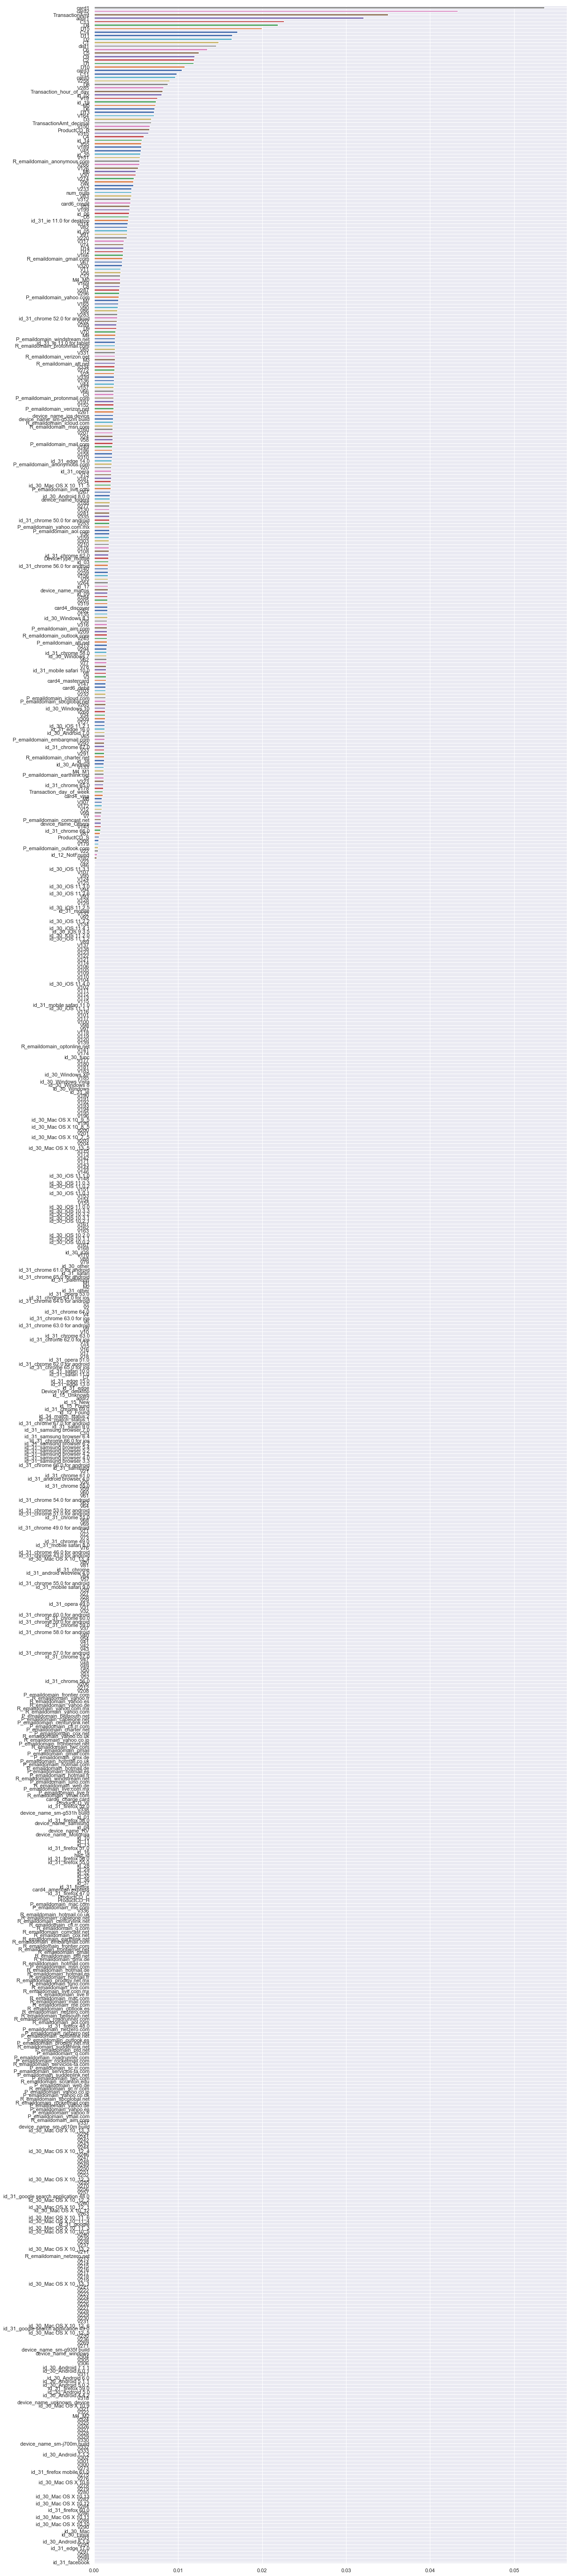

In [91]:
importances = pd.Series(ABC.feature_importances_, index = X.columns).sort_values()
importances.plot(kind = 'barh',figsize=[18,100]);

#### XGBOOST

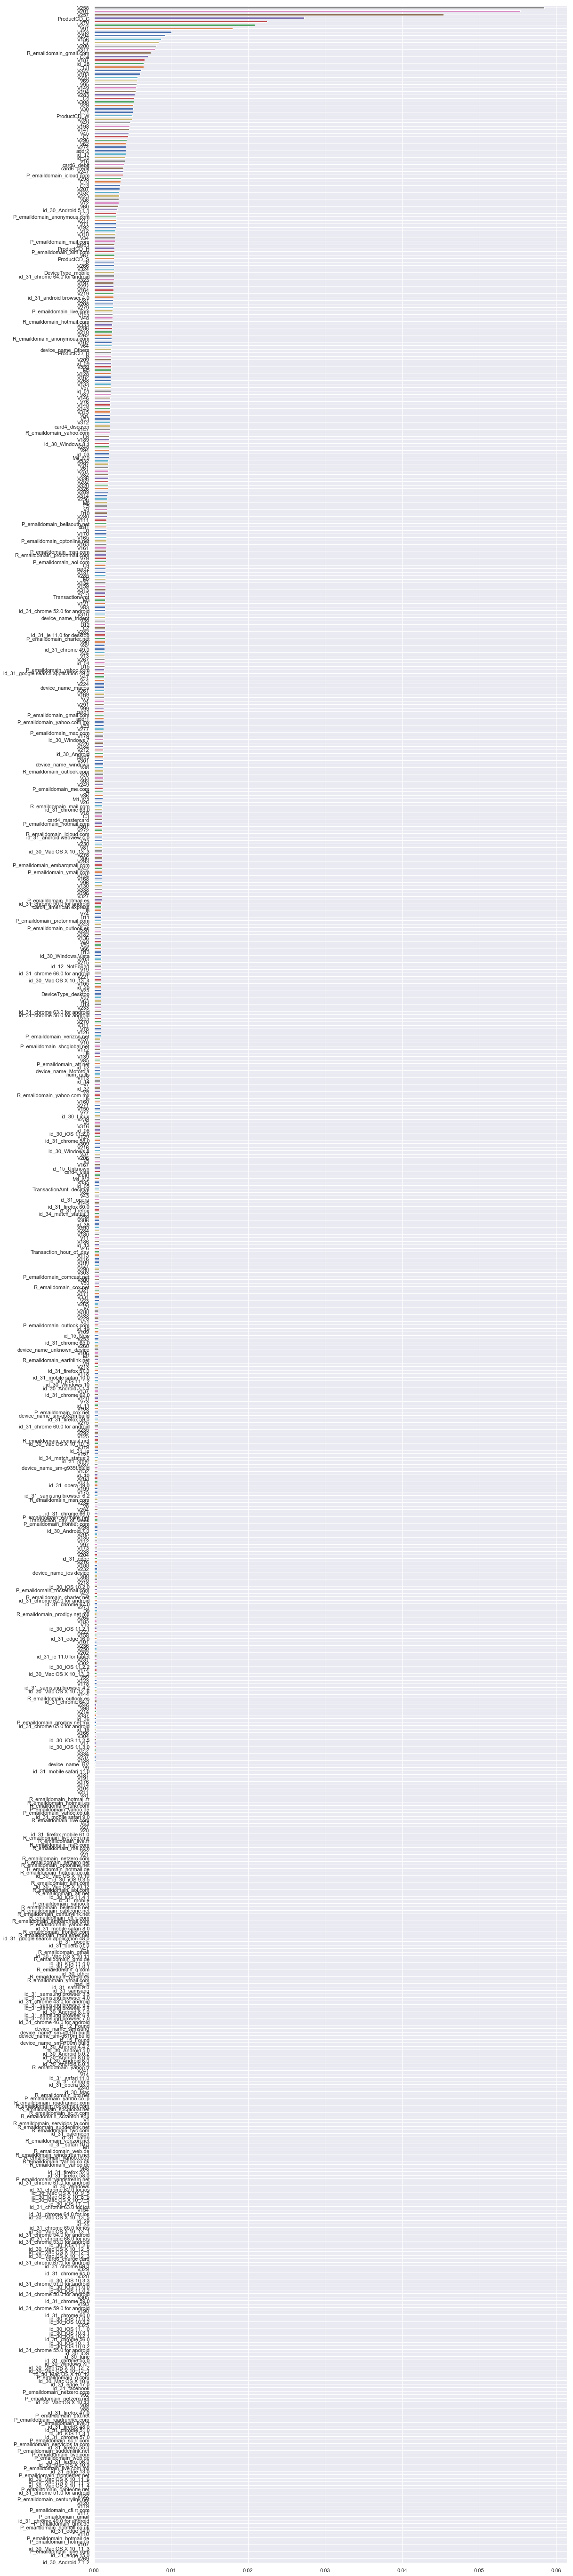

In [148]:
importances = pd.Series(clf.feature_importances_, index = X.columns).sort_values()
importances.plot(kind = 'barh',figsize=[18,100]);

## Let's compare distributions of Fraudulent and Non-Fraudulent Transactions for some of the important variables

In [ ]:
plt.figure(figsize=(14,6))
sns.distplot(X[y==0].card1,kde=True,label = 'not fraud')
sns.distplot(X[y==1].card1,kde=True,color='red',label = 'fraud')
plt.legend();

In [ ]:
plt.figure(figsize=(14,6))
sns.distplot(X[y==0].card2.dropna(),kde=True,label = 'not fraud')
sns.distplot(X[y==1].card2.dropna(),kde=True,color='red',label = 'fraud')
plt.legend();

In [ ]:
plt.figure(figsize=(14,6))
sns.distplot(np.log10(X[y==0].TransactionAmt),kde=True,label = 'not fraud')
sns.distplot(np.log10(X[y==1].TransactionAmt),kde=True,color='red',label = 'fraud')
plt.legend();

In [ ]:
plt.figure(figsize=(14,6))
sns.distplot(np.log(X[y==0]).C14,kde=True,label = 'not fraud')
sns.distplot(np.log(X[y==1]).C14,kde=True,color='red',label = 'fraud')
plt.legend();

In [ ]:
plt.figure(figsize=(14,6))
sns.distplot(X[y==0].C1,kde=True,label = 'not fraud')
sns.distplot(X[y==1].C1,kde=True,color='red',label = 'fraud')
plt.legend();

In [ ]:
plt.figure(figsize=(14,6))
sns.distplot(X[y==0].ProductCD,kde=True,label = 'not fraud')
sns.distplot(X[y==1].ProductCD,kde=True,color='red',label = 'fraud')
plt.legend();

In [ ]:
plt.figure(figsize=(14,6))
sns.distplot(X[y==0].D1,kde=True,label = 'not fraud')
sns.distplot(X[y==1].D1,kde=True,color='red',label = 'fraud')
plt.legend();

In [ ]:
sns.distplot(X.TransactionDT, kde=False, label = 'train set')
sns.distplot(test.TransactionDT,kde=False, color='red',label = 'test set')
plt.legend();

**We see that the dataset was split (Train and Test) by using the TransactionDT column. We should remove this from model training!**

In [ ]:
sns.distplot(X.TransactionID, kde=False, label = 'train set')
sns.distplot(test.TransactionID,kde=False, color='red',label = 'test set')
plt.legend();

**We see the same split with the TransactionID column. This can also be removed from model training**

In [ ]:
train.head()

In [ ]:
list(train.columns)

In [ ]:
plt.figure(figsize=(14,6))

z0 = np.log(X[y==0].D1.dropna())
z0 = z0[~z0.isin([-np.inf])]

z1 = np.log(X[y==1].D1.dropna())
z1 = z1[~z1.isin([-np.inf])]

sns.distplot(z0,kde=True,label = 'not fraud')
sns.distplot(z1,kde=True,color='red',label = 'fraud')
plt.legend();

In [ ]:
plt.figure(figsize=(14,6))

z0 = np.log(X[y==0].C13.dropna())
z0 = z0[~z0.isin([-np.inf])]

z1 = np.log(X[y==1].C13.dropna())
z1 = z1[~z1.isin([-np.inf])]

sns.distplot(z0,kde=True,label = 'not fraud')
sns.distplot(z1,kde=True,color='red',label = 'fraud')
plt.legend();

In [ ]:
plt.figure(figsize=(14,6))

z0 = np.log(X[y==0].D2.dropna())
z0 = z0[~z0.isin([-np.inf])]

z1 = np.log(X[y==1].D2.dropna())
z1 = z1[~z1.isin([-np.inf])]

sns.distplot(z0,kde=True,label = 'not fraud')
sns.distplot(z1,kde=True,color='red',label = 'fraud')
plt.legend();

In [ ]:
plt.figure(figsize=(14,6))

z0 = np.log(X[y==0].C8.dropna())
z0 = z0[~z0.isin([-np.inf,np.inf])]

z1 = np.log(X[y==1].C8.dropna())
z1 = z1[~z1.isin([-np.inf,np.inf])]

sns.distplot(z0,kde=True,label = 'not fraud')
sns.distplot(z1,kde=True,color='red',label = 'fraud')
plt.legend();

In [ ]:
plt.figure(figsize=(14,6))

z0 = np.log(X[y==0].V315.dropna())
z0 = z0[~z0.isin([-np.inf,np.inf])]

z1 = np.log(X[y==1].V315.dropna())
z1 = z1[~z1.isin([-np.inf,np.inf])]

sns.distplot(z0,kde=True,label = 'not fraud')
sns.distplot(z1,kde=True,color='red',label = 'fraud')
plt.legend();

In [ ]:
plt.figure(figsize=(14,6))

z0 = np.log(X[y==0].C5.dropna())
z0 = z0[~z0.isin([-np.inf,np.inf])]

z1 = np.log(X[y==1].C5.dropna())
z1 = z1[~z1.isin([-np.inf,np.inf])]

sns.distplot(z0,kde=True,label = 'not fraud')
sns.distplot(z1,kde=True,color='red',label = 'fraud')
plt.legend();

In [ ]:
plt.figure(figsize=(14,6))

z0 = X[y==0].num_nulls.dropna()
#z0 = z0[~z0.isin([-np.inf,np.inf,-999])]

z1 = X[y==1].num_nulls.dropna()
#z1 = z1[~z1.isin([-np.inf,np.inf,-999])]

sns.distplot(z0,kde=True,label = 'not fraud')
sns.distplot(z1,kde=True,color='red',label = 'fraud')
plt.legend();

In [ ]:
plt.figure(figsize=(14,6))

z0 = X[y==0].Transaction_hour_of_day.dropna()
#z0 = z0[~z0.isin([-np.inf,np.inf,-999])]

z1 = X[y==1].Transaction_hour_of_day.dropna()
#z1 = z1[~z1.isin([-np.inf,np.inf,-999])]

sns.distplot(z0,kde=True,label = 'not fraud')
sns.distplot(z1,kde=True,color='red',label = 'fraud')
plt.legend();

In [ ]:
plt.figure(figsize=(14,6))

z0 = np.log(X[y==0].C2.dropna())
z0 = z0[~z0.isin([-np.inf,np.inf,-999])]

z1 = np.log(X[y==1].C2.dropna())
z1 = z1[~z1.isin([-np.inf,np.inf,-999])]

sns.distplot(z0,kde=True,label = 'not fraud')
sns.distplot(z1,kde=True,color='red',label = 'fraud')
plt.legend();


In [ ]:
plt.figure(figsize=(14,6))

z0 = np.log(X[y==0].D7.dropna())
z0 = z0[~z0.isin([-np.inf,np.inf,-999])]

z1 = np.log(X[y==1].D7.dropna())
z1 = z1[~z1.isin([-np.inf,np.inf,-999])]

sns.distplot(z0,kde=True,label = 'not fraud')
sns.distplot(z1,kde=True,color='red',label = 'fraud')
plt.legend();


In [ ]:
plt.figure(figsize=(14,6))

z0 = np.log(X[y==0].V45.dropna())
z0 = z0[~z0.isin([-np.inf,np.inf,-999])]

z1 = np.log(X[y==1].V45.dropna())
z1 = z1[~z1.isin([-np.inf,np.inf,-999])]

sns.distplot(z0,kde=True,label = 'not fraud')
sns.distplot(z1,kde=True,color='red',label = 'fraud')
plt.legend();

In [ ]:
plt.figure(figsize=(14,6))

z0 = np.log(X[y==0].D8.dropna())
z0 = z0[~z0.isin([-np.inf,np.inf,-999])]

z1 = np.log(X[y==1].D8.dropna())
z1 = z1[~z1.isin([-np.inf,np.inf,-999])]

sns.distplot(z0,kde=True,label = 'not fraud')
sns.distplot(z1,kde=True,color='red',label = 'fraud')
plt.legend();

In [ ]:
plt.figure(figsize=(14,6))

z0 = np.log(X[y==0].V333.dropna())
z0 = z0[~z0.isin([-np.inf,np.inf,-999])]

z1 = np.log(X[y==1].V333.dropna())
z1 = z1[~z1.isin([-np.inf,np.inf,-999])]

sns.distplot(z0,kde=True,label = 'not fraud')
sns.distplot(z1,kde=True,color='red',label = 'fraud')
plt.legend();

In [ ]:
plt.figure(figsize=(14,6))

z0 = np.log10(X[y==0].C11.dropna())
z0 = z0[~z0.isin([-np.inf,np.inf,-999])]

z1 = np.log10(X[y==1].C11.dropna())
z1 = z1[~z1.isin([-np.inf,np.inf,-999])]

sns.distplot(z0,kde=True,label = 'not fraud')
sns.distplot(z1,kde=True,color='red',label = 'fraud')
plt.legend();

In [ ]:
plt.figure(figsize=(14,6))

z0 = np.log10(X[y==0].V265.dropna())
z0 = z0[~z0.isin([-np.inf,np.inf,-999])]

z1 = np.log10(X[y==1].V265.dropna())
z1 = z1[~z1.isin([-np.inf,np.inf,-999])]

sns.distplot(z0,kde=True,label = 'not fraud')
sns.distplot(z1,kde=True,color='red',label = 'fraud')
plt.legend();

In [ ]:
plt.figure(figsize=(14,6))

z0 = np.log10(X[y==0].V189.dropna())
z0 = z0[~z0.isin([-np.inf,np.inf,-999])]

z1 = np.log10(X[y==1].V189.dropna())
z1 = z1[~z1.isin([-np.inf,np.inf,-999])]

sns.distplot(z0,kde=True,label = 'not fraud')
sns.distplot(z1,kde=True,color='red',label = 'fraud')
plt.legend();

In [ ]:
plt.figure(figsize=(14,6))

z0 = X[y==0].D4.dropna()
z0 = z0[~z0.isin([-np.inf,np.inf,-999])]

z1 = X[y==1].D4.dropna()
z1 = z1[~z1.isin([-np.inf,np.inf,-999])]

sns.distplot(z0,kde=True,label = 'not fraud')
sns.distplot(z1,kde=True,color='red',label = 'fraud')
plt.legend();

In [ ]:
plt.figure(figsize=(14,6))

z0 = np.log(X[y==0].V318.dropna())
z0 = z0[~z0.isin([-np.inf,np.inf,-999])]

z1 = np.log(X[y==1].V318.dropna())
z1 = z1[~z1.isin([-np.inf,np.inf,-999])]

sns.distplot(z0,kde=True,label = 'not fraud')
sns.distplot(z1,kde=True,color='red',label = 'fraud')
plt.legend();

In [ ]:
plt.figure(figsize=(14,6))

z0 = X[y==0].V29.dropna()
z0 = z0[~z0.isin([-np.inf,np.inf,-999])]

z1 = X[y==1].V29.dropna()
z1 = z1[~z1.isin([-np.inf,np.inf,-999])]

sns.distplot(z0,kde=True,label = 'not fraud')
sns.distplot(z1,kde=True,color='red',label = 'fraud')
plt.legend();

In [ ]:
plt.figure(figsize=(14,6))

z0 = np.log(X[y==0].C9.dropna())
z0 = z0[~z0.isin([-np.inf,np.inf,-999])]

z1 = np.log(X[y==1].C9.dropna())
z1 = z1[~z1.isin([-np.inf,np.inf,-999])]

sns.distplot(z0,kde=True,label = 'not fraud')
sns.distplot(z1,kde=True,color='red',label = 'fraud')
plt.legend();

In [ ]:
plt.figure(figsize=(14,6))

z0 = np.log10(X[y==0].V82.dropna())
z0 = z0[~z0.isin([-np.inf,np.inf,-999])]

z1 = np.log10(X[y==1].V82.dropna())
z1 = z1[~z1.isin([-np.inf,np.inf,-999])]

sns.distplot(z0,kde=True,label = 'not fraud')
sns.distplot(z1,kde=True,color='red',label = 'fraud')
plt.legend();

In [ ]:
plt.figure(figsize=(14,6))

z0 = np.log10(X[y==0].D10.dropna())
z0 = z0[~z0.isin([-np.inf,np.inf,-999])]

z1 = np.log10(X[y==1].D10.dropna())
z1 = z1[~z1.isin([-np.inf,np.inf,-999])]

sns.distplot(z0,kde=True,label = 'not fraud')
sns.distplot(z1,kde=True,color='red',label = 'fraud')
plt.legend();

In [ ]:
plt.figure(figsize=(14,6))

z0 = np.log10(X[y==0].V274.dropna())
z0 = z0[~z0.isin([-np.inf,np.inf,-999])]

z1 = np.log10(X[y==1].V274.dropna())
z1 = z1[~z1.isin([-np.inf,np.inf,-999])]

sns.distplot(z0,kde=True,label = 'not fraud')
sns.distplot(z1,kde=True,color='red',label = 'fraud')
plt.legend();

In [ ]:
plt.figure(figsize=(14,6))

z0 = X[y==0].D4.dropna()
z0 = z0[~z0.isin([-np.inf,np.inf,-999])]

z1 = X[y==1].D4.dropna()
z1 = z1[~z1.isin([-np.inf,np.inf,-999])]

sns.distplot(z0,kde=True,label = 'not fraud')
sns.distplot(z1,kde=True,color='red',label = 'fraud')
plt.legend();

In [ ]:
plt.figure(figsize=(14,6))

z0 = X[y==0].num_nulls.dropna().astype(float)
z0 = z0[~z0.isin([-np.inf,np.inf,-999])]

z1 = X[y==1].num_nulls.dropna().astype(float)
z1 = z1[~z1.isin([-np.inf,np.inf,-999])]

sns.distplot(z0,kde=True,label = 'not fraud')
sns.distplot(z1,kde=True,color='red',label = 'fraud')
plt.legend();

In [ ]:
plt.figure(figsize=(14,6))

z0 = np.log(X[y==0].V318.dropna())
z0 = z0[~z0.isin([-np.inf,np.inf,-999])]

z1 = np.log(X[y==1].V318.dropna())
z1 = z1[~z1.isin([-np.inf,np.inf,-999])]

sns.distplot(z0,kde=True,label = 'not fraud')
sns.distplot(z1,kde=True,color='red',label = 'fraud')
plt.legend();

In [ ]:
plt.figure(figsize=(14,6))

z0 = X[y==0].V29.dropna()
z0 = z0[~z0.isin([-np.inf,np.inf,-999])]

z1 = X[y==1].V29.dropna()
z1 = z1[~z1.isin([-np.inf,np.inf,-999])]

sns.distplot(z0,kde=True,label = 'not fraud')
sns.distplot(z1,kde=True,color='red',label = 'fraud')
plt.legend();

In [ ]:
plt.figure(figsize=(14,6))

z0 = np.log10(X[y==0].C9.dropna())
z0 = z0[~z0.isin([-np.inf,np.inf,-999])]

z1 = np.log10(X[y==1].C9.dropna())
z1 = z1[~z1.isin([-np.inf,np.inf,-999])]

sns.distplot(z0,kde=True,label = 'not fraud')
sns.distplot(z1,kde=True,color='red',label = 'fraud')
plt.legend();

In [ ]:
plt.figure(figsize=(14,6))

z0 = np.log10(X[y==0].V82.dropna())
z0 = z0[~z0.isin([-np.inf,np.inf,-999])]

z1 = np.log10(X[y==1].V82.dropna())
z1 = z1[~z1.isin([-np.inf,np.inf,-999])]

sns.distplot(z0,kde=True,label = 'not fraud')
sns.distplot(z1,kde=True,color='red',label = 'fraud')
plt.legend();

In [ ]:
plt.figure(figsize=(14,6))

z0 = np.log10(X[y==0].D10.dropna())
z0 = z0[~z0.isin([-np.inf,np.inf,-999])]

z1 = np.log10(X[y==1].D10.dropna())
z1 = z1[~z1.isin([-np.inf,np.inf,-999])]

sns.distplot(z0,kde=True,label = 'not fraud')
sns.distplot(z1,kde=True,color='red',label = 'fraud')
plt.legend();

In [ ]:
plt.figure(figsize=(14,6))

z0 = np.log10(X[y==0].V274.dropna())
z0 = z0[~z0.isin([-np.inf,np.inf,-999])]

z1 = np.log10(X[y==1].V274.dropna())
z1 = z1[~z1.isin([-np.inf,np.inf,-999])]

sns.distplot(z0,kde=True,label = 'not fraud')
sns.distplot(z1,kde=True,color='red',label = 'fraud')
plt.legend();